Jupyter Notebook for AI_Weeder by Nicolai Bledow


In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer


2024-09-09 23:31:35.606751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 23:31:35.662799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 23:31:35.691287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 23:31:35.700557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 23:31:35.745609: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/nico/code/dorwein/ai_weeder/notebooks


In [3]:
# Change the working directory to the project's root
os.chdir('/home/nico/code/dorwein/ai_weeder')

# Confirm the change
print("New Working Directory:", os.getcwd())

New Working Directory: /home/nico/code/dorwein/ai_weeder


In [4]:
# Absolute path to the directory containing the images
main_dir = '/home/nico/code/dorwein/ai_weeder/raw_data/images_split/train'

def count_images_per_class(directory):
    class_counts = {}

    # Iterate through each folder in the main directory
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)

        # Ensure it's a directory
        if os.path.isdir(class_path):
            # Count files in the directory
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_folder] = num_images

    return class_counts


# Count images per class
class_image_counts = count_images_per_class(main_dir)
print(class_image_counts)

{'ShepherdÔÇÖs Purse': 446, 'Common Chickweed': 446, 'Fat Hen': 446, 'Cleavers': 446, 'Scentless Mayweed': 446, 'Common wheat': 446, 'Loose Silky-bent': 446, 'Small-flowered Cranesbill': 446, 'Black-grass': 446, 'Charlock': 446, 'Maize': 446, 'Sugar beet': 446}


In [5]:
# Absolute path to the directory containing the images
main_dir = '/home/nico/code/dorwein/ai_weeder/raw_data/images_split/train'


# Define image size and batch size
img_height, img_width = 128, 128
batch_size = 32

# Load dataset and split into training and validation sets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.15,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.15,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Retrieve class names before applying map
class_names = train_dataset.class_names
print(f"Class names: {class_names}")


Found 2676 files belonging to 12 classes.
Using 2275 files for training.


I0000 00:00:1725917498.860868   32366 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-09 23:31:39.075723: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 2676 files belonging to 12 classes.
Using 401 files for validation.
Class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdÔÇÖs Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [6]:
# Check some properties of the dataset
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

val_dataset

Images shape: (32, 128, 128, 3)
Labels shape: (32,)
Images shape: (32, 128, 128, 3)
Labels shape: (32,)


2024-09-09 23:31:39.539579: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-09 23:31:39.658723: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
# Check a sample of labels to ensure they are integers
for images, labels in train_dataset.take(1):
    print(f"Sample labels: {labels.numpy()}")

Sample labels: [10  1  1  9 10  5 10  7  8  9  2  8 11  3  3  3  2  6  8 10 11  4  6 11
 11  1 11  9  7  4  9  6]


2024-09-09 23:31:39.827291: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


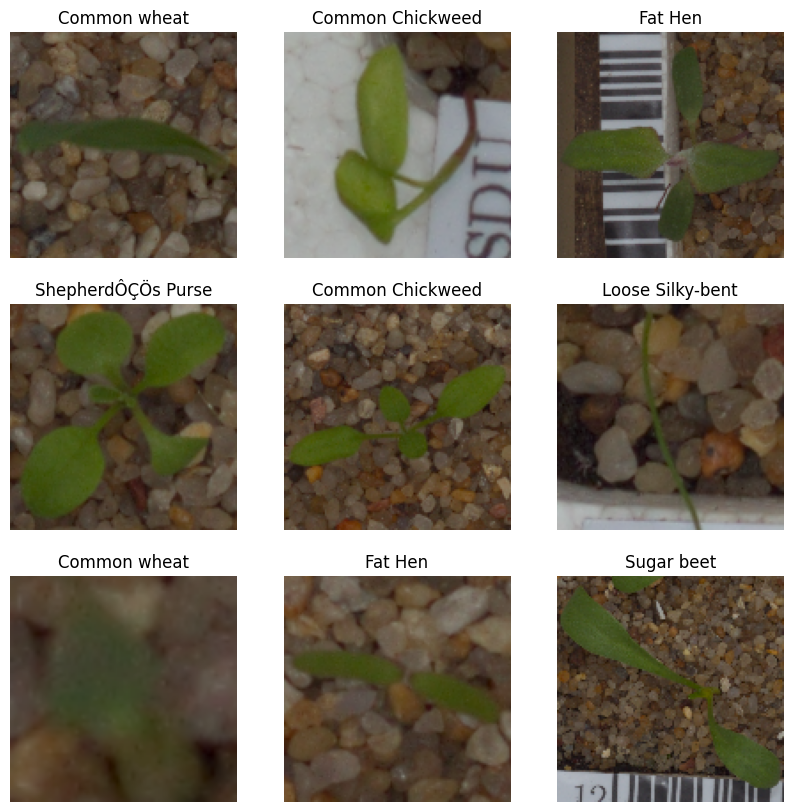

In [8]:
# Plotting some examples from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

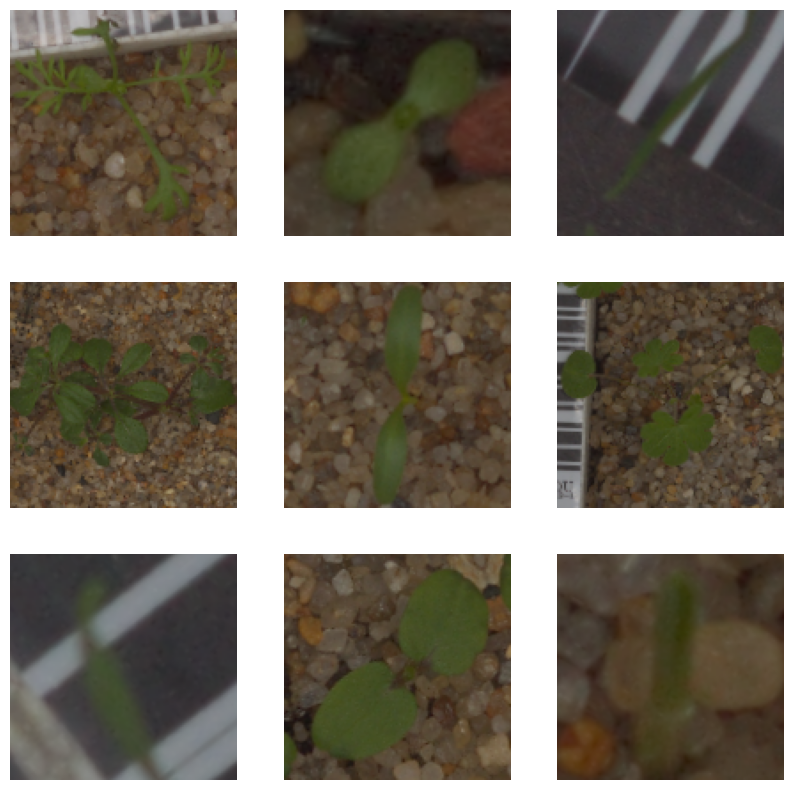

In [9]:
# tf.layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomContrast(0.3)
])

# Applying data augmentation and showing an example
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [10]:
# Using green to create a layer filter

# Reference color in CIELUV space (for green adjustment)
reference_color = tf.convert_to_tensor([40.0, -12.0, 18.0], dtype=tf.float32)


# Custom CIELUV Distance Layer
class CIELUVDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, reference_color, **kwargs):
        super(CIELUVDistanceLayer, self).__init__(**kwargs)
        self.reference_color = tf.convert_to_tensor(reference_color, dtype=tf.float32)

    def rgb_to_xyz(self, rgb):
        """ Convert RGB to XYZ color space """

        # RGB to XYZ conversion matrix
        rgb = tf.clip_by_value(rgb, 0.0, 1.0)
        mask = (rgb > 0.04045)
        rgb = tf.where(mask, tf.pow((rgb + 0.055) / 1.055, 2.4), rgb / 12.92)

        # D65 illuminant
        rgb = rgb * 100.0
        x = 0.4124 * rgb[..., 0] + 0.3576 * rgb[..., 1] + 0.1805 * rgb[..., 2]
        y = 0.2126 * rgb[..., 0] + 0.7152 * rgb[..., 1] + 0.0722 * rgb[..., 2]
        z = 0.0193 * rgb[..., 0] + 0.1192 * rgb[..., 1] + 0.9505 * rgb[..., 2]
        return tf.stack([x, y, z], axis=-1)

    def xyz_to_cieluv(self, xyz):
        """ Convert XYZ to CIELUV color space """

        # Reference white
        ref_x = 95.047
        ref_y = 100.000
        ref_z = 108.883
        # Normalize XYZ by reference white

        x, y, z = xyz[..., 0] / ref_x, xyz[..., 1] / ref_y, xyz[..., 2] / ref_z
        # Compute L*

        mask = (y > 0.008856)
        L = tf.where(mask, 116.0 * tf.pow(y, 1/3) - 16.0, 903.3 * y)

        # Compute u* and v*
        u_prime = 4 * x / (x + 15 * y + 3 * z + 1e-7)
        v_prime = 9 * y / (x + 15 * y + 3 * z + 1e-7)
        u_ref = 4 * ref_x / (ref_x + 15 * ref_y + 3 * ref_z)
        v_ref = 9 * ref_y / (ref_x + 15 * ref_y + 3 * ref_z)
        u = 13 * L * (u_prime - u_ref)
        v = 13 * L * (v_prime - v_ref)
        return tf.stack([L, u, v], axis=-1)
    def call(self, inputs):
        # Normalize inputs to range [0, 1]
        inputs = inputs / 255.0

        # Convert RGB to XYZ
        xyz_images = self.rgb_to_xyz(inputs)

        # Convert XYZ to CIELUV
        cieluv_images = self.xyz_to_cieluv(xyz_images)

        # Compute the Euclidean distance in CIELUV space
        delta = cieluv_images - self.reference_color
        distance = tf.sqrt(tf.reduce_sum(tf.square(delta), axis=-1, keepdims=True))
        return distance


In [11]:
# Check some properties of the dataset
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")


Images shape: (32, 128, 128, 3)
Labels shape: (32,)
Images shape: (32, 128, 128, 3)
Labels shape: (32,)


In [12]:

# tf.keras.models

# Define the CNN model with more kernels
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Normalization layer (scales pixel values to [0, 1])
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))

    # 2. convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.1))

    # 3. convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    CIELUVDistanceLayer(reference_color=reference_color)

    model.add(layers.Dropout(0.2))

    # 4. convolutional block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.3))


    # 5. convolutional block
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.GlobalAveragePooling2D())  # Use GlobalAveragePooling here

    model.add(layers.Dropout(0.4))


    # Flatten the 3D feature maps to 1D feature vectors
    model.add(layers.Flatten())
    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Set input shape and number of classes
input_shape = (128, 128, 3)
num_classes = 12

# Create the CNN model
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model with the custom loss function
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


# Display the model architecture
cnn_model.summary()

/home/nico/.pyenv/versions/3.10.6/envs/ai_weeder/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,618,188 (6.17 MB)

 Trainable params: 1,618,188 (6.17 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
epochs = 140

# Train the CNN model
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    #class_weight=class_weights_nb,
    verbose=1,
    callbacks=[early_stopping],
)


Epoch 1/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 380ms/step - accuracy: 0.0861 - loss: 2.4913 - val_accuracy: 0.1247 - val_loss: 2.4708
Epoch 2/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 451ms/step - accuracy: 0.1208 - loss: 2.4077 - val_accuracy: 0.1820 - val_loss: 2.1690
Epoch 3/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - accuracy: 0.1884 - loss: 2.1112 - val_accuracy: 0.2020 - val_loss: 2.1022
Epoch 4/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.2199 - loss: 2.0394 - val_accuracy: 0.2693 - val_loss: 1.8601
Epoch 5/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.2508 - loss: 1.9314 - val_accuracy: 0.3292 - val_loss: 1.8205
Epoch 6/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 463ms/step - accuracy: 0.2762 - loss: 1.8412 - val_accuracy: 0.3392 - val_loss: 1.6584
Epoch 7/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - accuracy: 0.3209 - loss: 1.7460 - val_accuracy: 0.3317 - val_loss: 1.7667
Epoch 8/140
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 437ms/step - accuracy: 0.3078 - loss: 1.7648 - 

In [14]:
# Evaluate the model and calculate F1 Score
evaluate = cnn_model.evaluate(val_dataset)
evaluate

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8464 - loss: 0.4103


[0.40251946449279785, 0.8603491187095642]

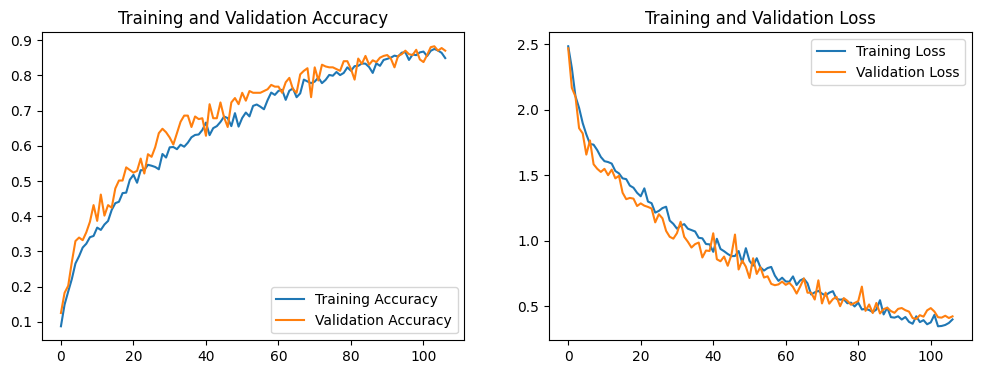

In [16]:
# Retrieve metrics from the history
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Determine the number of epochs actually trained
epochs_trained = len(acc)

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Recompile the model with a lower learning rate for fine-tuning
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Use a lower learning rate
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Fine-tune the model
history_fine = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Adjust as needed
)

In [ ]:
# Retrieve metrics from the history
acc = history_fine.history.get('accuracy', [])
val_acc = history_fine.history.get('val_accuracy', [])
loss = history_fine.history.get('loss', [])
val_loss = history_fine.history.get('val_loss', [])

# Determine the number of epochs actually trained
epochs_trained = len(acc)

# Plot training and validation accuracy

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


2024-09-10 00:34:43.326905: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


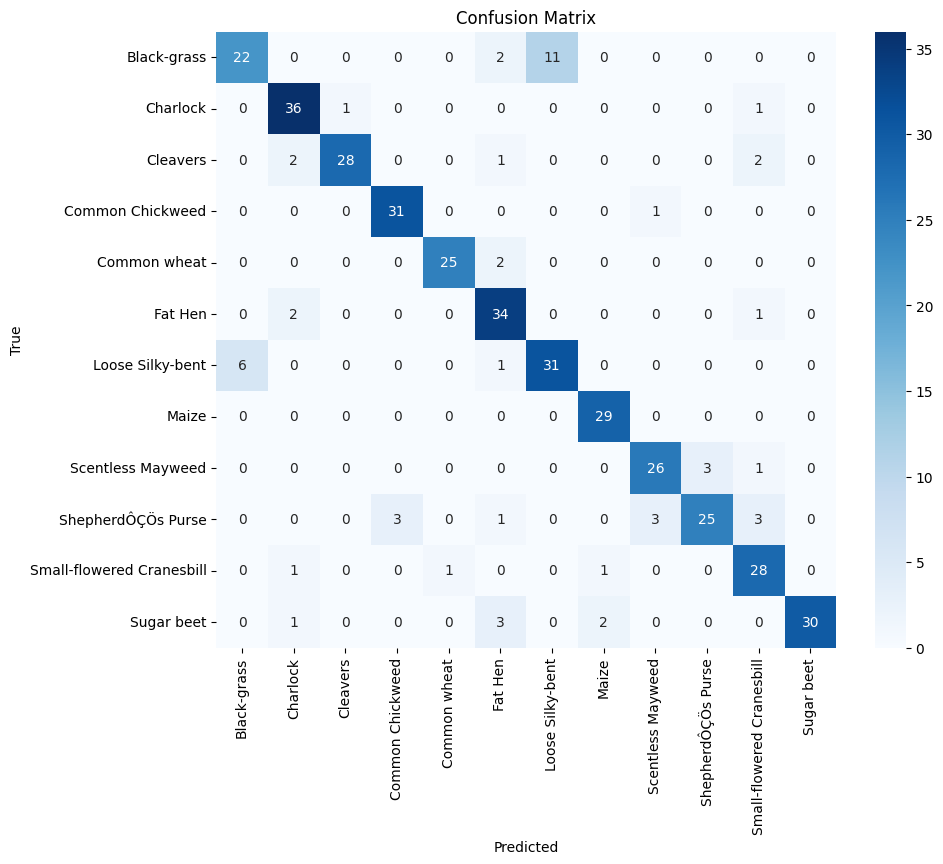

In [17]:

# Get the true labels and predicted labels from the validation set
true_labels = []
predicted_labels = []

# Loop over the validation set to collect true labels and predictions
for images, labels in val_dataset:
    # Get model predictions
    preds = cnn_model.predict(images)
    # Convert predictions from probabilities to class indices
    predicted_class_indices = np.argmax(preds, axis=1)

    true_labels.extend(labels.numpy())  # Append true labels
    predicted_labels.extend(predicted_class_indices)  # Append predicted labels

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average=None)  # 'average=None' gives precision per class
recall = recall_score(true_labels, predicted_labels, average=None)        # 'average=None' gives recall per class
# accuracy = accuracy_score(true_labels, predicted_labels)        # 'average=None' gives accuracy per class

# Display precision and recall for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    # print(f"Accuracy: {accuracy[i]}")
    print('-' * 30)

# If you want to calculate the macro or weighted averages for overall precision and recall:
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
# macro_accuracy = accuracy_score(true_labels, predicted_labels, average='macro')

weighted_precision = precision_score(true_labels, predicted_labels, average='weighted')
weighted_recall = recall_score(true_labels, predicted_labels, average='weighted')
# weighted_accuracy = accuracy_score(true_labels, predicted_labels, average='weighted')

print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
# print(f"Weighted Accuracy: {weighted_accuracy}")

Class: Black-grass
Precision: 0.7857142857142857
Recall: 0.6285714285714286
------------------------------
Class: Charlock
Precision: 0.8571428571428571
Recall: 0.9473684210526315
------------------------------
Class: Cleavers
Precision: 0.9655172413793104
Recall: 0.8484848484848485
------------------------------
Class: Common Chickweed
Precision: 0.9117647058823529
Recall: 0.96875
------------------------------
Class: Common wheat
Precision: 0.9615384615384616
Recall: 0.9259259259259259
------------------------------
Class: Fat Hen
Precision: 0.7727272727272727
Recall: 0.918918918918919
------------------------------
Class: Loose Silky-bent
Precision: 0.7380952380952381
Recall: 0.8157894736842105
------------------------------
Class: Maize
Precision: 0.90625
Recall: 1.0
------------------------------
Class: Scentless Mayweed
Precision: 0.8666666666666667
Recall: 0.8666666666666667
------------------------------
Class: ShepherdÔÇÖs Purse
Precision: 0.8928571428571429
Recall: 0.71428571

In [19]:

# Calculate Macro F1 Score
macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)

# Calculate Weighted F1 Score
weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)

print(f"Macro F1 Score: {macro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")

Macro F1 Score: 0.8669654504417683
Weighted F1 Score: 0.8632723231105477


In [20]:

# Calculate the F1 score (micro-averaged)
micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

# Calculate the F1 score (weighted, macro, or other averaging methods if needed)
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Micro-Averaged F1 Score: {micro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")
print(f"Macro F1 Score: {macro_f1}")

Micro-Averaged F1 Score: 0.8603491271820449
Weighted F1 Score: 0.8590628363697527
Macro F1 Score: 0.8629153150478964


Original images shape: (32, 128, 128, 3)
Transformed images shape: (32, 128, 128, 1)


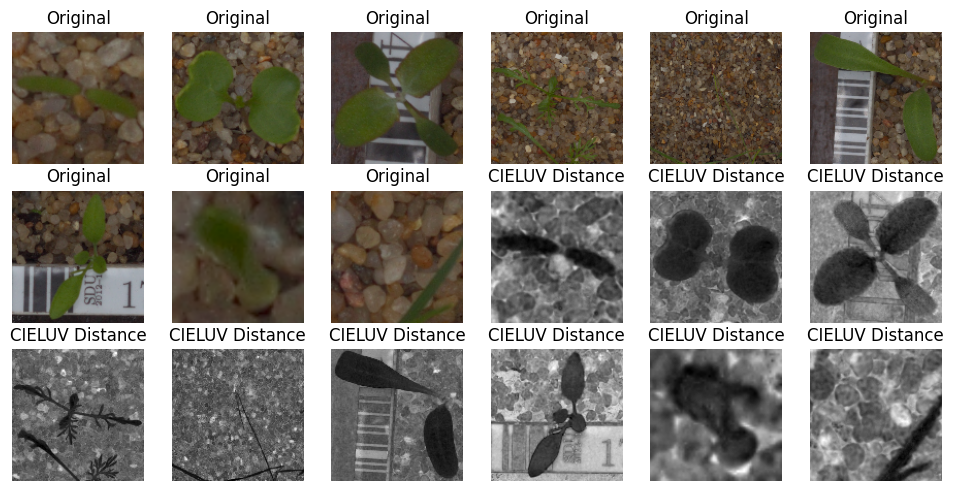

In [21]:

reference_color_test = tf.convert_to_tensor([40.0, -12.0, 18.0], dtype=tf.float32)

def visualize_cieluv_output(dataset, cieluv_layer):
    # Take one batch of images from the dataset
    for images, _ in dataset.take(1):
        # Apply the CIELUV layer
        transformed_images = cieluv_layer(images)

        # Check shapes of the outputs
        print(f"Original images shape: {images.shape}")
        print(f"Transformed images shape: {transformed_images.shape}")

        # Plot the original and transformed images
        plt.figure(figsize=(12, 12))
        for i in range(min(9, images.shape[0])):  # Show up to 9 images
            # Original image
            ax = plt.subplot(6, 6, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Original")
            plt.axis("off")

            # Transformed image
            ax = plt.subplot(6, 6, i + 10)
            # The output of the CIELUV layer is a single channel, so we need to display it as a grayscale image
            plt.imshow(np.squeeze(transformed_images[i].numpy()), cmap='gray')
            plt.title("CIELUV Distance")
            plt.axis("off")

        plt.show()

# Create an instance of the CIELUVDistanceLayer
cieluv_layer = CIELUVDistanceLayer(reference_color=reference_color_test)

# Visualize the output of the CIELUV layer on some images from the training dataset
visualize_cieluv_output(train_dataset, cieluv_layer)

In [22]:
# Absolute path to the directory containing the test images
test_dir = '/home/nico/code/dorwein/ai_weeder/raw_data/images_split/test'

# Define image size and batch size (ensure it's the same size as used during training)
img_height, img_width = 128, 128  # Use the size expected by MobileNetV2 (224x224)
batch_size = 10  # Adjust this as needed

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Do not shuffle for testing
)

# Check class names to verify correct loading
print(f"Class names: {test_dataset.class_names}")

Found 360 files belonging to 12 classes.
Class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdÔÇÖs Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [23]:
# Get the class predictions for the test dataset
predictions = cnn_model.predict(test_dataset)

# Convert the predicted probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get the true labels from the dataset
true_labels = tf.concat([y for x, y in test_dataset], axis=0)

# Compare predicted and true labels (optional)
print(f"Predicted labels: {predicted_labels.numpy()}")
print(f"True labels: {true_labels.numpy()}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Predicted labels: [ 0  0  0  0  0  0  0  6  0  0  6  0  6  0  0  0  0  0  6  0  6  0  0  0
  0  0  0  0  0  6  1  1  1  8  1  1  1  1  2  1  1  1  1  1  1  1  1  1
 10  1  1  1  5  7  1  1  1  1 10  1  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  1  2  2  5  2  2  2 11  2  2  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  5  3  4  4  4  4  4  4  4  4  4  4  4  4  7  4  4  4  4  4  4  4
  5  4  4  4  4  4 10  5  5 10  5  5  5  5  2  5  5  5  5  5  5  5  5  3
  5  5  4  5  5  5  5  5  5  5  5  5  6  0  6  6  6  6  6  6  6  6  6  0
  6  6  6  6  6  6  6  6  6  6  0  6  6  6  6  6  6  6  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  3  8  8  8  8  8  8  8  8  8  8  8 10  8  8  8
  8  8  8  8  8  8  8  9  9  9  9  8  9  9  9  9  8  8  8  9  9  9  9  9
  9  9  9  8 10  9 10 10  8  9  9 10 10 10 10 10 10 10 10 10 10 10

In [24]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8629 - loss: 0.4900
Test Loss: 0.39917612075805664
Test Accuracy: 0.8777777552604675


In [25]:
from sklearn.metrics import classification_report

# Get classification report
print(classification_report(true_labels.numpy(), predicted_labels.numpy(), target_names=test_dataset.class_names))

                           precision    recall  f1-score   support

              Black-grass       0.89      0.80      0.84        30
                 Charlock       0.96      0.80      0.87        30
                 Cleavers       0.93      0.90      0.92        30
         Common Chickweed       0.91      1.00      0.95        30
             Common wheat       0.96      0.87      0.91        30
                  Fat Hen       0.83      0.83      0.83        30
         Loose Silky-bent       0.82      0.90      0.86        30
                    Maize       0.94      1.00      0.97        30
        Scentless Mayweed       0.78      0.93      0.85        30
       ShepherdÔÇÖs Purse       0.95      0.63      0.76        30
Small-flowered Cranesbill       0.72      0.97      0.83        30
               Sugar beet       0.96      0.90      0.93        30

                 accuracy                           0.88       360
                macro avg       0.89      0.88      0.88    

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


<Figure size 1000x800 with 0 Axes>

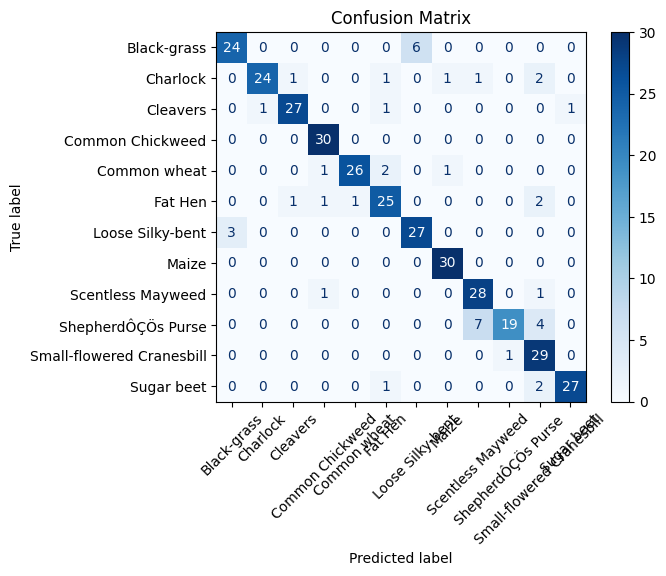

In [26]:
# Get the class predictions for the test dataset
predictions = cnn_model.predict(test_dataset)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the dataset
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names).plot(cmap='Blues')
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()